In [1]:
import rootpath
import sys
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import numpy as np
from testsuite.utilities import Pareto_split

In [8]:
def image_infill(x, F=None, front_value = 0., n_contours=20):
    #figure_properties
    fig = plt.figure(figsize=[9,7])
    ax = fig.gca()
    ax.set_xlim([0,1.5])
    ax.set_ylim([0,1.5])
    
    
    p, d = Pareto_split(x)
    
    # compute infill
    M, N = 100, 100
    x = np.linspace(0, 1.5, M)
    y = np.linspace(0, 1.5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    
    if F == None:
        F = lambda x: np.zeros(x.shape[0])
    zz = F(xy)
    zz = zz.reshape(N,M)
    
    #image infill
    pcol = ax.pcolor(xx, yy, zz, alpha=0.8)
    levels = np.linspace(zz.min(), zz.max(), n_contours)
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
    
    # scatter samples
    ax.scatter(d[:,0], d[:,1], c="C0", label="dominated samples")
    ax.scatter(p[:,0], p[:,1], c="C3", label="non-dominated samples")
    fig.colorbar(pcol)
    fig.legend()
    
    return fig

In [3]:
np.random.seed(6)
y = np.random.uniform(1,10,size = (12,2))
y = np.array([[0.1, 0.95], [0.2, 0.5], [0.35, 0.3], [0.44, 0.25], [0.5, 0.15], [0.78, 0.12], [1.1, 0.05]])

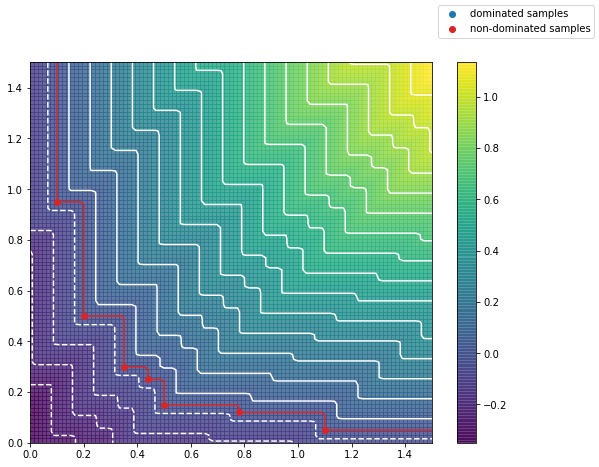

In [9]:
from testsuite.optimisers import Saf
from testsuite.surrogates import GP, MultiSurrogate

saf_opt = Saf(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=None)
saf_opt.y = y
F_saf = lambda x_q: saf_opt.saf(x_q, Pareto_split(y)[0], invert=True)
fig_saf = image_infill(x=y, F=F_saf)

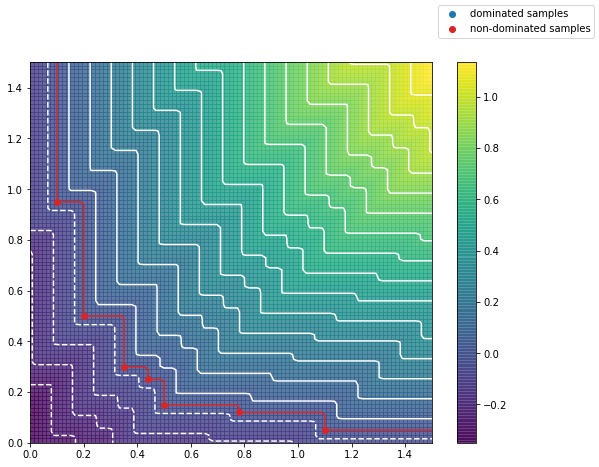

In [10]:
from testsuite.optimisers import Saf
from testsuite.surrogates import GP, MultiSurrogate

saf_opt = Saf(objective_function=lambda x: x[0:2], ei=True,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=None)
saf_opt.y = y
uncertainty = 0.1
F_saf = lambda x_q: saf_opt.saf(x_q, Pareto_split(y)[0], invert=True)
fig_saf = image_infill(x=y, F=F_saf)

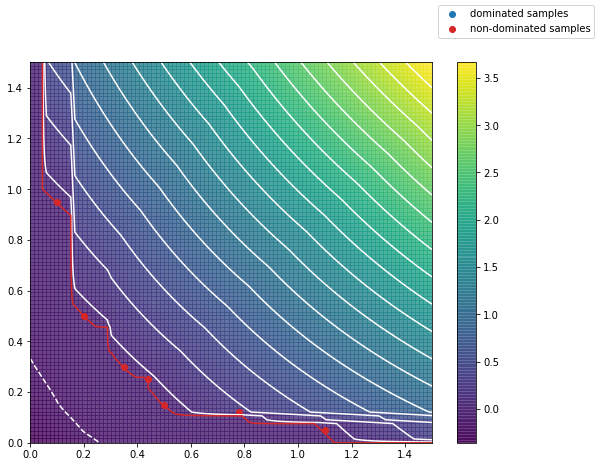

In [11]:
from testsuite.optimisers import SmsEgo
sms_opt = SmsEgo(objective_function=lambda x: x[:,0:2], surrogate=MultiSurrogate(GP), limits = [[0, 0, 0, 0, 0], [1,1,1,1,1]])
sms_opt.y = y
uncertainty = 0
sms_opt.current_hv = sms_opt._compute_hypervolume()
F_sms = lambda x_q: np.array([sms_opt._scalarise_y(x_qi.reshape(1, -1), np.ones_like(x_qi.reshape(1, -1))*uncertainty, invert=True) for x_qi in x_q])
fig_sms = image_infill(x=y, F=F_sms)

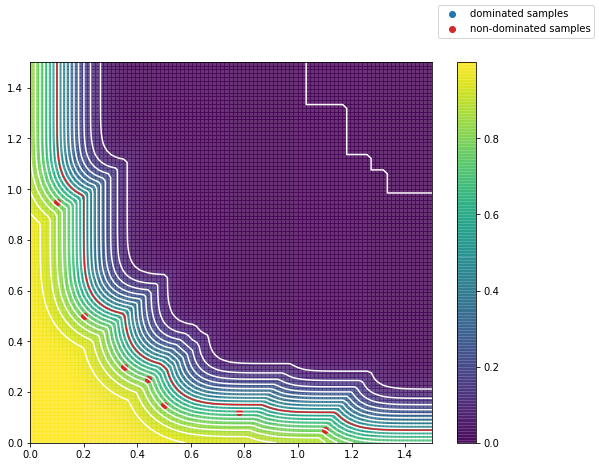

In [16]:
from testsuite.optimisers import Mpoi 
mpoi_opt = Mpoi(objective_function=lambda x: x[:,0:2], surrogate=MultiSurrogate(GP), limits = [[0, 0, 0, 0, 0], [1,1,1,1,1]])
mpoi_opt.y = y
uncertainty = 0.1
F_mpoi = lambda x_q: np.array([mpoi_opt._scalarise_y(x_qi.reshape(1, -1), np.ones_like(x_qi.reshape(1, -1))*uncertainty) for x_qi in x_q])
fig_mpoi = image_infill(x=y, F=F_mpoi, front_value=0.5)